#Import

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
# import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


#Build Network

In [ ]:
delta = 1

class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return  x* self.sigmoid(x)

activation = nn.GELU()
activation_ = torch.tanh

In [ ]:
M = 128
selu = Swish()

T = True
F = False

class Net_3D(nn.Module):
    def __init__(self):
        super(Net_3D, self).__init__()
        torch.manual_seed(1234) # Fix Initial_Parameter
        self.hidden_layer1 = nn.Linear(3,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer2 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer3 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer4 = nn.Linear(M,M, bias = T)
        # torch.manual_seed(1234)
        # self.hidden_layer5 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.output_layer = nn.Linear(M,3, bias = T)

    def forward(self, x,y,z):
        inputs = torch.cat([x,y,z],axis=1)
        layer1_out = activation(self.hidden_layer1(inputs))
        layer2_out = activation(self.hidden_layer2(layer1_out))
        layer3_out = activation(self.hidden_layer3(layer2_out))
        layer4_out = activation(self.hidden_layer4(layer3_out))
        # layer5_out = activation(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer4_out)

        return output

class Net_3D_f(nn.Module):
    def __init__(self):
        super(Net_3D_f, self).__init__()
        torch.manual_seed(1234) # Fix Initial_Parameter
        self.hidden_layer1 = nn.Linear(3,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer2 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer3 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.hidden_layer4 = nn.Linear(M,M, bias = T)
        # torch.manual_seed(1234)
        # self.hidden_layer5 = nn.Linear(M,M, bias = T)
        torch.manual_seed(1234)
        self.output_layer = nn.Linear(M,3, bias = T)

    def forward(self, x,y,z):
        inputs = torch.cat([x,y,z],axis=1)
        layer1_out = activation_(self.hidden_layer1(inputs))
        layer2_out = activation_(self.hidden_layer2(layer1_out))
        layer3_out = activation_(self.hidden_layer3(layer2_out))
        layer4_out = activation_(self.hidden_layer4(layer3_out))
        # layer5_out = activation(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer4_out)

        return output

#loss,optimize

In [ ]:
import torch
import torch.nn.init as init

### (2) Model
mse_cost_function = torch.nn.MSELoss() #MSE Function can be shared

net_3d_1 = Net_3D()
net_3d_1 = net_3d_1.to(device)

net_3d_2 = Net_3D()
net_3d_2 = net_3d_2.to(device)


net_3d_f = Net_3D_f()
net_3d_f = net_3d_f.to(device)

net_3d_f0 = Net_3D_f()
net_3d_f0 = net_3d_f0.to(device)

optimizer1 = torch.optim.Adam(net_3d_1.parameters(),lr=0.001)
optimizer2 = torch.optim.Adam(net_3d_2.parameters(),lr=0.001)
optimizerf = torch.optim.Adam(net_3d_f.parameters(),lr=0.001)
optimizerf0 = torch.optim.Adam(net_3d_f0.parameters(),lr=0.001)

#set PDE,residual
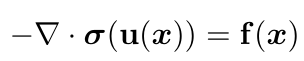

In [ ]:
N = 1
C = 0.05
lamb = 10000
mu = 1

def f(x,y,z,  x_bd,y_bd,z_bd,  net1,net2,netf,netf0,  epoch):
    f1 = ((lamb + 2*mu)/lamb)*torch.sin(x)-mu*z*torch.sin(x)*torch.sin(y)*(6-2*z**2)
    f2 = ((lamb + 2*mu)/lamb)*torch.sin(y)-mu*z*torch.cos(x)*torch.cos(y)*(30-10*z**2)
    f3 = ((lamb + 2*mu)/lamb)*torch.sin(z)-mu*(z**2)*torch.cos(x)*torch.sin(y)*(12-2*z**2)

    u1 = net1(x,y,z)[:, 0:1]
    v1 = net1(x,y,z)[:, 1:2] #u_tilda
    w1 = net1(x,y,z)[:, 2:3]

    u2 = net2(x,y,z)[:, 0:1]
    v2 = net2(x,y,z)[:, 1:2] #u_hat
    w2 = net2(x,y,z)[:, 2:3]

    net_f1 = netf(x,y,z)[:, 0:1]
    net_f2 = netf(x,y,z)[:, 1:2] #f_hat
    net_f3 = netf(x,y,z)[:, 2:3]

    net_f01 = netf0(x,y,z)[:, 0:1]
    net_f02 = netf0(x,y,z)[:, 1:2] #f_hat
    net_f03 = netf0(x,y,z)[:, 2:3]

    u1_bdy = net1(x_bd,y_bd,z_bd)[:, 0:1]
    v1_bdy = net1(x_bd,y_bd,z_bd)[:, 1:2] #u_tilda_bdy
    w1_bdy = net1(x_bd,y_bd,z_bd)[:, 2:3]

    u2_bdy = net2(x_bd,y_bd,z_bd)[:, 0:1]
    v2_bdy = net2(x_bd,y_bd,z_bd)[:, 1:2] #u_hat_bdy
    w2_bdy = net2(x_bd,y_bd,z_bd)[:, 2:3]

    bd_u1 = (z_bd**3) * torch.sin(x_bd) * torch.sin(y_bd) + (1/lamb) * torch.sin(x_bd)
    bd_u2 = 5 * (z_bd**3) * torch.cos(x_bd) * torch.cos(y_bd) + (1/lamb) * torch.sin(y_bd)
    bd_u3 = (z_bd**4) * torch.cos(x_bd) * torch.sin(y_bd) + (1/lamb) * torch.sin(z_bd)

    u1_x = torch.autograd.grad(u1.sum(), x, create_graph=True)[0]
    u1_y = torch.autograd.grad(u1.sum(), y, create_graph=True)[0]
    u1_z = torch.autograd.grad(u1.sum(), z, create_graph=True)[0]
    u1_xx = torch.autograd.grad(u1_x.sum(), x, create_graph=True)[0]
    u1_yy = torch.autograd.grad(u1_y.sum(), y, create_graph=True)[0]
    u1_zz = torch.autograd.grad(u1_z.sum(), z, create_graph=True)[0]
    u1_xy = torch.autograd.grad(u1_x.sum(), y, create_graph=True)[0]
    u1_xz = torch.autograd.grad(u1_x.sum(), z, create_graph=True)[0]

    v1_x = torch.autograd.grad(v1.sum(), x, create_graph=True)[0]
    v1_y = torch.autograd.grad(v1.sum(), y, create_graph=True)[0]
    v1_z = torch.autograd.grad(v1.sum(), z, create_graph=True)[0]
    v1_xx = torch.autograd.grad(v1_x.sum(), x, create_graph=True)[0]
    v1_yy = torch.autograd.grad(v1_y.sum(), y, create_graph=True)[0]
    v1_zz = torch.autograd.grad(v1_z.sum(), z, create_graph=True)[0]
    v1_yx = torch.autograd.grad(v1_y.sum(), x, create_graph=True)[0]
    v1_yz = torch.autograd.grad(v1_y.sum(), z, create_graph=True)[0]

    w1_x = torch.autograd.grad(w1.sum(), x, create_graph=True)[0]
    w1_y = torch.autograd.grad(w1.sum(), y, create_graph=True)[0]
    w1_z = torch.autograd.grad(w1.sum(), z, create_graph=True)[0]
    w1_xx = torch.autograd.grad(w1_x.sum(), x, create_graph=True)[0]
    w1_yy = torch.autograd.grad(w1_y.sum(), y, create_graph=True)[0]
    w1_zz = torch.autograd.grad(w1_z.sum(), z, create_graph=True)[0]
    w1_zx = torch.autograd.grad(w1_z.sum(), x, create_graph=True)[0]
    w1_zy = torch.autograd.grad(w1_z.sum(), y, create_graph=True)[0]

    u2_x = torch.autograd.grad(u2.sum(), x, create_graph=True)[0]
    u2_y = torch.autograd.grad(u2.sum(), y, create_graph=True)[0]
    u2_z = torch.autograd.grad(u2.sum(), z, create_graph=True)[0]
    u2_xx = torch.autograd.grad(u2_x.sum(), x, create_graph=True)[0]
    u2_yy = torch.autograd.grad(u2_y.sum(), y, create_graph=True)[0]
    u2_zz = torch.autograd.grad(u2_z.sum(), z, create_graph=True)[0]
    u2_xy = torch.autograd.grad(u2_x.sum(), y, create_graph=True)[0]
    u2_xz = torch.autograd.grad(u2_x.sum(), z, create_graph=True)[0]

    v2_x = torch.autograd.grad(v2.sum(), x, create_graph=True)[0]
    v2_y = torch.autograd.grad(v2.sum(), y, create_graph=True)[0]
    v2_z = torch.autograd.grad(v2.sum(), z, create_graph=True)[0]
    v2_xx = torch.autograd.grad(v2_x.sum(), x, create_graph=True)[0]
    v2_yy = torch.autograd.grad(v2_y.sum(), y, create_graph=True)[0]
    v2_zz = torch.autograd.grad(v2_z.sum(), z, create_graph=True)[0]
    v2_yx = torch.autograd.grad(v2_y.sum(), x, create_graph=True)[0]
    v2_yz = torch.autograd.grad(v2_y.sum(), z, create_graph=True)[0]

    w2_x = torch.autograd.grad(w2.sum(), x, create_graph=True)[0]
    w2_y = torch.autograd.grad(w2.sum(), y, create_graph=True)[0]
    w2_z = torch.autograd.grad(w2.sum(), z, create_graph=True)[0]
    w2_xx = torch.autograd.grad(w2_x.sum(), x, create_graph=True)[0]
    w2_yy = torch.autograd.grad(w2_y.sum(), y, create_graph=True)[0]
    w2_zz = torch.autograd.grad(w2_z.sum(), z, create_graph=True)[0]
    w2_zx = torch.autograd.grad(w2_z.sum(), x, create_graph=True)[0]
    w2_zy = torch.autograd.grad(w2_z.sum(), y, create_graph=True)[0]

    U1_dual_r1 = ((-mu*(u1_xx + u1_yy + u1_zz + u1_xx + v1_yx + w1_zx) - net_f01)**2).mean()
    U1_dual_r2 = ((-mu*(v1_xx + v1_yy + v1_zz + u1_xy + v1_yy + w1_zy) - net_f02)**2).mean()
    U1_dual_r3 = ((-mu*(w1_xx + w1_yy + w1_zz + u1_xz + v1_yz + w1_zz) - net_f03)**2).mean()
    U1_r1 = ((-(lamb)*(u1_xx + v1_yx + w1_zx) - net_f1)**2).mean()
    U1_r2 = ((-(lamb)*(u1_xy + v1_yy + w1_zy) - net_f2)**2).mean()
    U1_r3 = ((-(lamb)*(u1_xz + v1_yz + w1_zz) - net_f3)**2).mean()

    U2_r1 = ((-mu*(u2_xx + u2_yy + u2_zz + u2_xx + v2_yx + w2_zx) - f1 + net_f1 + net_f01)**2).mean()
    U2_r2 = ((-mu*(v2_xx + v2_yy + v2_zz + u2_xy + v2_yy + w2_zy) - f2 + net_f2 + net_f02)**2).mean()
    U2_r3 = ((-mu*(w2_xx + w2_yy + w2_zz + u2_xz + v2_yz + w2_zz) - f3 + net_f3 + net_f03)**2).mean()
    U2_dual_r1 = ((u2_xx + v2_yx + w2_zx)**2).mean()
    U2_dual_r2 = ((u2_xy + v2_yy + w2_zy)**2).mean()
    U2_dual_r3 = ((u2_xz + v2_yz + w2_zz)**2).mean()

    bdy1_loss = ((u1_bdy + u2_bdy - bd_u1)**2).mean()
    bdy2_loss = ((v1_bdy + v2_bdy - bd_u2)**2).mean()
    bdy3_loss = ((w1_bdy + w2_bdy - bd_u3)**2).mean()


    return U1_dual_r1 + U1_dual_r2 + U1_dual_r3 + C*U1_r1 + C*U1_r2 + C*U1_r3 + U2_dual_r1 + U2_dual_r2 + U2_dual_r3 + U2_r1 + U2_r2 + U2_r3 + 100*bdy1_loss + 100*bdy2_loss + 100*bdy3_loss


def f_1(x,y,z,  x_bd,y_bd,z_bd,  net1,  epoch):
    f1 = ((lamb + 2*mu)/lamb)*torch.sin(x)-mu*z*torch.sin(x)*torch.sin(y)*(6-2*z**2)
    f2 = ((lamb + 2*mu)/lamb)*torch.sin(y)-mu*z*torch.cos(x)*torch.cos(y)*(30-10*z**2)
    f3 = ((lamb + 2*mu)/lamb)*torch.sin(z)-mu*(z**2)*torch.cos(x)*torch.sin(y)*(12-2*z**2)

    u1 = net1(x,y,z)[:, 0:1]
    v1 = net1(x,y,z)[:, 1:2] #u_tilda
    w1 = net1(x,y,z)[:, 2:3]

    u1_bdy = net1(x_bd,y_bd,z_bd)[:, 0:1]
    v1_bdy = net1(x_bd,y_bd,z_bd)[:, 1:2] #u_tilda_bdy
    w1_bdy = net1(x_bd,y_bd,z_bd)[:, 2:3]

    bd_u1 = (z_bd**3) * torch.sin(x_bd) * torch.sin(y_bd) + (1/lamb) * torch.sin(x_bd)
    bd_u2 = 5 * (z_bd**3) * torch.cos(x_bd) * torch.cos(y_bd) + (1/lamb) * torch.sin(y_bd)
    bd_u3 = (z_bd**4) * torch.cos(x_bd) * torch.sin(y_bd) + (1/lamb) * torch.sin(z_bd)

    u1_x = torch.autograd.grad(u1.sum(), x, create_graph=True)[0]
    u1_y = torch.autograd.grad(u1.sum(), y, create_graph=True)[0]
    u1_z = torch.autograd.grad(u1.sum(), z, create_graph=True)[0]
    u1_xx = torch.autograd.grad(u1_x.sum(), x, create_graph=True)[0]
    u1_yy = torch.autograd.grad(u1_y.sum(), y, create_graph=True)[0]
    u1_zz = torch.autograd.grad(u1_z.sum(), z, create_graph=True)[0]
    u1_xy = torch.autograd.grad(u1_x.sum(), y, create_graph=True)[0]
    u1_xz = torch.autograd.grad(u1_x.sum(), z, create_graph=True)[0]

    v1_x = torch.autograd.grad(v1.sum(), x, create_graph=True)[0]
    v1_y = torch.autograd.grad(v1.sum(), y, create_graph=True)[0]
    v1_z = torch.autograd.grad(v1.sum(), z, create_graph=True)[0]
    v1_xx = torch.autograd.grad(v1_x.sum(), x, create_graph=True)[0]
    v1_yy = torch.autograd.grad(v1_y.sum(), y, create_graph=True)[0]
    v1_zz = torch.autograd.grad(v1_z.sum(), z, create_graph=True)[0]
    v1_yx = torch.autograd.grad(v1_y.sum(), x, create_graph=True)[0]
    v1_yz = torch.autograd.grad(v1_y.sum(), z, create_graph=True)[0]

    w1_x = torch.autograd.grad(w1.sum(), x, create_graph=True)[0]
    w1_y = torch.autograd.grad(w1.sum(), y, create_graph=True)[0]
    w1_z = torch.autograd.grad(w1.sum(), z, create_graph=True)[0]
    w1_xx = torch.autograd.grad(w1_x.sum(), x, create_graph=True)[0]
    w1_yy = torch.autograd.grad(w1_y.sum(), y, create_graph=True)[0]
    w1_zz = torch.autograd.grad(w1_z.sum(), z, create_graph=True)[0]
    w1_zx = torch.autograd.grad(w1_z.sum(), x, create_graph=True)[0]
    w1_zy = torch.autograd.grad(w1_z.sum(), y, create_graph=True)[0]

    U1_r1 = ((-mu*(u1_xx + u1_yy + u1_zz + u1_xx + v1_yx + w1_zx)-(lamb)*(u1_xx + v1_yx + w1_zx) - f1)**2).mean()
    U1_r2 = ((-mu*(v1_xx + v1_yy + v1_zz + u1_xy + v1_yy + w1_zy)-(lamb)*(u1_xy + v1_yy + w1_zy) - f2)**2).mean()
    U1_r3 = ((-mu*(w1_xx + w1_yy + w1_zz + u1_xz + v1_yz + w1_zz)-(lamb)*(u1_xz + v1_yz + w1_zz) - f3)**2).mean()

    bdy1_loss = ((u1_bdy - bd_u1)**2).mean()
    bdy2_loss = ((v1_bdy - bd_u2)**2).mean()
    bdy3_loss = ((w1_bdy - bd_u3)**2).mean()

    return C*U1_r1 + C*U1_r2 + C*U1_r3 + 100*bdy1_loss + 100*bdy2_loss + 100*bdy3_loss

#Set data point

In [ ]:
##----------------------------------------boundary-------------------------------------------#$
x = np.linspace(0, 1, 16)
y = np.linspace(0, 1, 16)

#
X, Y = np.meshgrid(x, y)

#
faces = [
    np.column_stack([np.zeros_like(X.flatten()), Y.flatten(), X.flatten()]),  # x=0
    np.column_stack([np.full_like(X.flatten(), 1), Y.flatten(), X.flatten()]),  # x=1
    np.column_stack([X.flatten(), np.zeros_like(X.flatten()), Y.flatten()]),  # y=0
    np.column_stack([X.flatten(), np.full_like(X.flatten(), 1), Y.flatten()]),  # y=1
    np.column_stack([X.flatten(), Y.flatten(), np.zeros_like(X.flatten())]),  # z=0
    np.column_stack([X.flatten(), Y.flatten(), np.full_like(X.flatten(), 1)]),  # z=1
]

# print(faces)

all_coords = np.vstack(faces)  # shape: (16x16x6, 3)

x_coords = all_coords[:, 0].reshape(-1, 1)  # x 좌표 (16x16x6, 1)
y_coords = all_coords[:, 1].reshape(-1, 1)  # y 좌표 (16x16x6, 1)
z_coords = all_coords[:, 2].reshape(-1, 1)  # z 좌표 (16x16x6, 1)

bdy_x_collocation = Variable(torch.from_numpy(x_coords).float(), requires_grad=True).to(device)
bdy_y_collocation = Variable(torch.from_numpy(y_coords).float(), requires_grad=True).to(device)
bdy_z_collocation = Variable(torch.from_numpy(z_coords).float(), requires_grad=True).to(device)

print(len(bdy_z_collocation))
# print(bdy_z_collocation)

1536


# Learn F

In [ ]:
x_collocation = np.random.uniform(low = 0 , high = 1 , size=(8000,1))
y_collocation = np.random.uniform(low = 0 , high = 1 , size=(8000,1)) # 많이 뽑으면 GPU 용량 초과 뜹니다
z_collocation = np.random.uniform(low = 0 , high = 1 , size=(8000,1))

f_x_col = Variable(torch.from_numpy(x_collocation).float(), requires_grad=False).to(device)
f_y_col = Variable(torch.from_numpy(y_collocation).float(), requires_grad=False).to(device)
f_z_col = Variable(torch.from_numpy(z_collocation).float(), requires_grad=False).to(device)

pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True).to(device)
pt_z_collocation = Variable(torch.from_numpy(z_collocation).float(), requires_grad=True).to(device)

label_f1 = ((lamb-2*mu)/lamb)*torch.sin(f_x_col)-mu*f_z_col*torch.sin(f_x_col)*torch.sin(f_y_col)*(6-2*(f_z_col**2))
label_f2 = ((lamb-2*mu)/lamb)*torch.sin(f_y_col)-mu*f_z_col*torch.cos(f_x_col)*torch.cos(f_y_col)*(30-10*(f_z_col**2))
label_f3 = ((lamb-2*mu)/lamb)*torch.sin(f_z_col)-mu*(f_z_col**2)*torch.cos(f_x_col)*torch.sin(f_y_col)*(12-2*(f_z_col**2))

In [ ]:
previous_validation_loss = 99999999.0
gap3 = 1
epoch = 0

while epoch < 3000:
    optimizerf.zero_grad()

##------------------------------------Compute Loss-----------------------------------------##

    pred_f_1 = net_3d_f(f_x_col, f_y_col, f_z_col)[:, 0:1]
    pred_f_2 = net_3d_f(f_x_col, f_y_col, f_z_col)[:, 1:2]
    pred_f_3 = net_3d_f(f_x_col, f_y_col, f_z_col)[:, 2:3]

    msef_1 = mse_cost_function(pred_f_1, (0.3)*label_f1)
    msef_2 = mse_cost_function(pred_f_2, (0.3)*label_f2)
    msef_3 = mse_cost_function(pred_f_3, (0.3)*label_f3) # initial f_hat = 0.5f

    loss_f = 0.1*(msef_1 + msef_2 + msef_3)

##------------------------------------Optimize Loss-----------------------------------------##

    loss_f.backward()
    optimizerf.step()

    epoch += 1

    if epoch % 100 == 1:
        print("MSE Error: ", loss_f.item())

MSE Error:  1.0046335458755493
MSE Error:  0.016272246837615967
MSE Error:  0.004436073359102011
MSE Error:  0.0014741317136213183
MSE Error:  0.000644952931907028
MSE Error:  0.00028225165442563593
MSE Error:  0.00017460434173699468
MSE Error:  0.0001254840026376769
MSE Error:  9.614345617592335e-05
MSE Error:  7.958261994645e-05
MSE Error:  6.497970753116533e-05
MSE Error:  9.152237180387601e-05
MSE Error:  4.806090873898938e-05
MSE Error:  4.139557859161869e-05
MSE Error:  0.0001814972929423675
MSE Error:  3.3012718631653115e-05
MSE Error:  2.8965698220417835e-05
MSE Error:  2.5607367206248455e-05
MSE Error:  4.1211635107174516e-05
MSE Error:  2.1420957637019455e-05
MSE Error:  1.9090808564214967e-05
MSE Error:  1.7158547052531503e-05
MSE Error:  4.9099868192570284e-05
MSE Error:  1.4918044143996667e-05
MSE Error:  1.350447018921841e-05
MSE Error:  1.4111103155300952e-05
MSE Error:  1.4637150343332905e-05
MSE Error:  1.1133269254059996e-05
MSE Error:  1.030205748975277e-05
MSE Error

In [ ]:
previous_validation_loss = 99999999.0
gap3 = 1
epoch = 0

while epoch < 3000:
    optimizerf0.zero_grad()

##------------------------------------Compute Loss-----------------------------------------##

    pred_f_01 = net_3d_f0(f_x_col, f_y_col, f_z_col)[:, 0:1]
    pred_f_02 = net_3d_f0(f_x_col, f_y_col, f_z_col)[:, 1:2]
    pred_f_03 = net_3d_f0(f_x_col, f_y_col, f_z_col)[:, 2:3]

    msef_01 = mse_cost_function(pred_f_01, (0.3)*label_f1)
    msef_02 = mse_cost_function(pred_f_02, (0.3)*label_f2)
    msef_03 = mse_cost_function(pred_f_03, (0.3)*label_f3) # initial f_hat = 0.5f

    loss_f0 = 0.1*(msef_01 + msef_02 + msef_03)

##------------------------------------Optimize Loss-----------------------------------------##

    loss_f0.backward()
    optimizerf0.step()

    epoch += 1

    if epoch % 100 == 1:
        print("MSE Error: ", loss_f.item())

MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06
MSE Error:  9.42385941016255e-06


#Train

In [ ]:
Iterlist = []
Error_decom = []

Error_stan = []

In [ ]:
Error_stan = []

In [ ]:
x_ = np.arange(0,1,0.1)
y_ = np.arange(0,1,0.1)
z_ = np.arange(0,1,0.1)

ms_x_ , ms_y_, ms_z_= np.meshgrid(x_,y_,z_)

x_ = np.ravel(ms_x_).reshape(-1,1)
y_ = np.ravel(ms_y_).reshape(-1,1)
z_ = np.ravel(ms_z_).reshape(-1,1)

pt_x_ = Variable(torch.from_numpy(x_).float(), requires_grad=False).to(device)
pt_y_ = Variable(torch.from_numpy(y_).float(), requires_grad=False).to(device)
pt_z_ = Variable(torch.from_numpy(z_).float(), requires_grad=False).to(device)

sol_u1 = (pt_z_**3) * torch.sin(pt_x_) * torch.sin(pt_y_) + (1/lamb) * torch.sin(pt_x_)
sol_u2 = 5 * (pt_z_**3) * torch.cos(pt_x_) * torch.cos(pt_y_) + (1/lamb) * torch.sin(pt_y_)
sol_u3 = (pt_z_**4) * torch.cos(pt_x_) * torch.sin(pt_y_) + (1/lamb) * torch.sin(pt_z_)

In [ ]:
previous_validation_loss = 99999999.0
gap3 = 1
epoch = 0

while epoch < 50000:
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizerf.zero_grad()
    optimizerf0.zero_grad()
##------------------------------------Compute Loss-----------------------------------------##

    loss = 1*f(pt_x_collocation, pt_y_collocation, pt_z_collocation, bdy_x_collocation, bdy_y_collocation, bdy_z_collocation , net_3d_1, net_3d_2, net_3d_f,net_3d_f0, epoch)
    # loss = 1*f_1(pt_x_collocation, pt_y_collocation, pt_z_collocation, bdy_x_collocation, bdy_y_collocation, bdy_z_collocation , net_3d_1, epoch)

##------------------------------------Optimize Loss-----------------------------------------##

    loss.backward()
    optimizer1.step()
    optimizer2.step()
    optimizerf.step()
    optimizerf0.step()

    epoch += 1


##----------------------------Result-----------------------------##
    if (epoch) % 200 == 1:
        print("-----------------------------------------------------------------------------")
        gap1 = torch.sqrt((((((net_3d_1(pt_x_,pt_y_,pt_z_)+net_3d_2(pt_x_,pt_y_,pt_z_))[:,0:1]) - sol_u1)**2).mean())/(((sol_u1)**2).mean()))
        gap2 = torch.sqrt((((((net_3d_1(pt_x_,pt_y_,pt_z_)+net_3d_2(pt_x_,pt_y_,pt_z_))[:,1:2]) - sol_u2)**2).mean())/(((sol_u2)**2).mean()))
        gap3 = torch.sqrt((((((net_3d_1(pt_x_,pt_y_,pt_z_)+net_3d_2(pt_x_,pt_y_,pt_z_))[:,2:3]) - sol_u3)**2).mean())/(((sol_u3)**2).mean()))

        # gap1 = torch.sqrt((((((net_3d_1(pt_x_,pt_y_,pt_z_))[:,0:1]) - sol_u1)**2).mean())/(((sol_u1)**2).mean()))
        # gap2 = torch.sqrt((((((net_3d_1(pt_x_,pt_y_,pt_z_))[:,1:2]) - sol_u2)**2).mean())/(((sol_u2)**2).mean()))
        # gap3 = torch.sqrt((((((net_3d_1(pt_x_,pt_y_,pt_z_))[:,2:3]) - sol_u3)**2).mean())/(((sol_u3)**2).mean()))

        print("Epoch:",epoch)
        print("Loss :", (loss).item())
        print(gap1.item())
        Iterlist.append(epoch)
        Error_decom.append((gap1+gap2+gap3).item()/3)
        # Error_stan.append((gap1+gap2+gap3).item()/3)

-----------------------------------------------------------------------------
Epoch: 1
Loss : 402.9927673339844
1.7847357988357544
-----------------------------------------------------------------------------
Epoch: 201
Loss : 1.1077641248703003
0.3852773904800415
-----------------------------------------------------------------------------
Epoch: 401
Loss : 0.297912061214447
0.14289188385009766
-----------------------------------------------------------------------------
Epoch: 601
Loss : 0.19500379264354706
0.10770069807767868
-----------------------------------------------------------------------------
Epoch: 801
Loss : 0.14379778504371643
0.08402880281209946
-----------------------------------------------------------------------------
Epoch: 1001
Loss : 0.11522358655929565
0.06929054856300354
-----------------------------------------------------------------------------
Epoch: 1201
Loss : 0.21432873606681824
0.05501975119113922
-------------------------------------------------------

In [ ]:
A=np.load("/content/err_std_3d.npy")

#Plotting Prediction

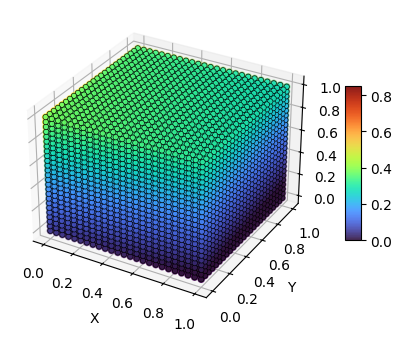

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. data
n_points = 25
x_ = np.linspace(0, 1, n_points)
y_ = np.linspace(0, 1, n_points)
z_ = np.linspace(0, 1, n_points)

X, Y, Z = np.meshgrid(x_, y_, z_)

x_ = np.ravel(X).reshape(-1,1)
y_ = np.ravel(Y).reshape(-1,1)
z_ = np.ravel(Z).reshape(-1,1)

pt_x_ = Variable(torch.from_numpy(x_).float(), requires_grad=False).to(device)
pt_y_ = Variable(torch.from_numpy(y_).float(), requires_grad=False).to(device)
pt_z_ = Variable(torch.from_numpy(z_).float(), requires_grad=False).to(device)

# 2. Predict
pt_u = ((net_3d_2(pt_x_, pt_y_, pt_z_) + net_3d_1(pt_x_,pt_y_, pt_z_))[:,2])

# pt_u = (pt_z_**3) * torch.sin(pt_x_) * torch.sin(pt_y_) + (1/lamb) * torch.sin(pt_x_)
# pt_u = 5 * (pt_z_**3) * torch.cos(pt_x_) * torch.cos(pt_y_) + (1/lamb) * torch.sin(pt_y_)
# pt_u = (pt_z_**4) * torch.cos(pt_x_) * torch.sin(pt_y_) + (1/lamb) * torch.sin(pt_z_)

# pt_u = (( net_3d_1(pt_x_,pt_y_, pt_z_))[:,2:3])
u = pt_u.data.cpu().numpy()
ms_u = u.reshape(X.shape)

# 3. visualization
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X, Y, Z, c=ms_u, cmap='viridis', marker='o',vmin=0)

sc = ax.scatter(
    X, Y, Z,
    c=ms_u,
    cmap='turbo',
    marker='o',
    s=15,
    edgecolors='k',
    linewidths=0.5,
    alpha=0.9,
    vmin=0,vmax=0.85
)

# 컬러바 추가
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('Function Value (u1)')

# 그래프 꾸미기
# ax.set_title("4D Function Visualization in 3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

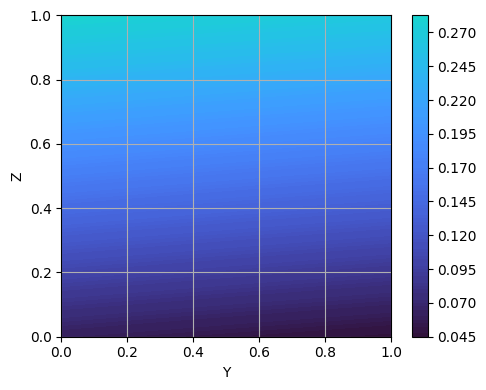

In [ ]:
# x=0.5
tol = 0.01
mask = np.abs(X - 0.5) < tol
Y_cut = Y[mask]
Z_cut = Z[mask]
ms_u_cut = ms_u[mask]

plt.figure(figsize=(5,4))
# 삼각분할 기반 등고선 채우기
contour = plt.tricontourf(Y_cut, Z_cut, ms_u_cut, levels=100, cmap='turbo',vmax=0.85)
cbar = plt.colorbar(contour)
# cbar.set_label("Function value w")

plt.xlabel("Y")
plt.ylabel("Z")
# plt.title("Cross-section at x = 0.5")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot learning curves

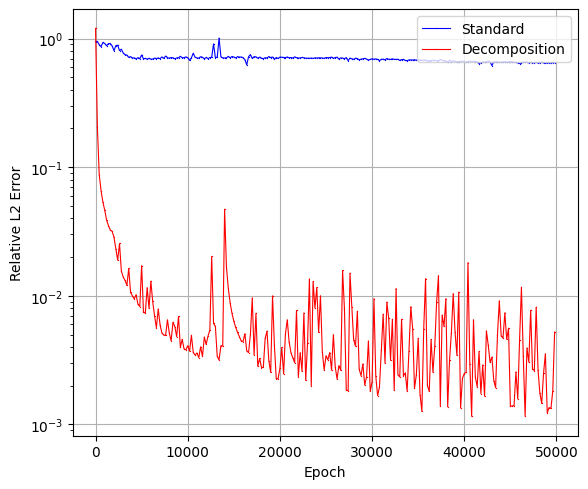

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))


plt.plot(Iterlist, A ,color = 'blue', marker='x',markersize=0.3,label='Standard',linewidth = "0.8")
plt.plot(Iterlist, Error_decom ,color = 'red', marker='x',markersize=0.3,label='Decomposition',linewidth = "0.8")

plt.xlabel('Epoch')
plt.ylabel('Relative L2 Error')
# plt.title('Learning Curve')
plt.yscale("log")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
plt.close()